# LDA demo
### source: https://gist.github.com/georgehc/d2353feef7e09b4b53fc087d44f75954

In [1]:
import nltk
import json
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
import random
from gensim.models import CoherenceModel

/Users/xinpengzheng/anaconda3/lib/python3.6/site-packages/scipy/sparse/sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [4]:
content = []
for line in open('JACS.json', 'r'):
    content.append(json.loads(line))

## To load eupmc.json

In [3]:
content = []
with open('eupmc.json') as json_data:
    content = json.load(json_data)

FileNotFoundError: [Errno 2] No such file or directory: 'eupmc.json'

In [5]:
Total = []
for c in content:
    ##using both title and content
    total = c['Title']
    Total.append(total)
    
#print(Total)

In [6]:
vocab_size = 1000
from sklearn.feature_extraction.text import CountVectorizer

# document frequency (df) means number of documents a word appears in
tf_vectorizer = CountVectorizer(max_df=0.95,
                                min_df=2,
                                max_features=vocab_size,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(Total)

In [7]:
num_topics = 20

from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=num_topics, learning_method='online', random_state=95865)
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=20, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=95865, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [8]:
import numpy as np
topic_word_distributions = np.array([topic_word_pseudocounts / np.sum(topic_word_pseudocounts)
                                     for topic_word_pseudocounts in lda.components_])

In [9]:
num_top_words = 10

print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
print()

import numpy as np
for topic_idx in range(num_topics):
    print('[Topic %d]' % topic_idx)
    sort_indices = np.argsort(topic_word_distributions[topic_idx])[::-1]
    for rank in range(num_top_words):
        word_idx = sort_indices[rank]
        print('%s: %f' % (tf_vectorizer.get_feature_names()[word_idx], topic_word_distributions[topic_idx, word_idx]))
    print()


Displaying the top 10 words per topic and their probabilities within the topic...

[Topic 0]
catalyzed: 0.099926
enantioselective: 0.050113
asymmetric: 0.026763
synthesis: 0.019837
using: 0.019002
nickel: 0.018188
chiral: 0.017714
reductive: 0.017294
cross: 0.016656
complexes: 0.014703

[Topic 1]
acid: 0.061242
assisted: 0.054093
release: 0.047830
rapid: 0.035966
programmable: 0.035471
triggered: 0.031625
investigation: 0.028476
labeling: 0.027890
bioorthogonal: 0.026798
nucleic: 0.026212

[Topic 2]
high: 0.054280
structure: 0.048515
organic: 0.039508
metal: 0.035060
single: 0.028299
using: 0.027342
framework: 0.024956
performance: 0.022302
molecule: 0.021918
crystal: 0.017482

[Topic 3]
organic: 0.063362
metal: 0.061175
assembly: 0.057230
hydrogen: 0.044041
frameworks: 0.039535
self: 0.039458
covalent: 0.024860
evolution: 0.017076
framework: 0.016176
new: 0.015526

[Topic 4]
synthesis: 0.088919
acid: 0.035682
total: 0.027334
oxidative: 0.021218
biosynthesis: 0.017681
temperature: 0.01

# Another Way of doing LDA
### Source: https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html

In [10]:
from nltk.corpus import stopwords 
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(entry).split() for entry in Total]

#print(doc_clean)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xinpengzheng/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/xinpengzheng/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
import gensim
from gensim import corpora,models

random.shuffle(Total)

training = Total[:round(len(Total)*0.6)]
test = Total[round(len(Total)*0.6):]

doc_clean_train = [clean(entry).split() for entry in training]
doc_clean_test = [clean(entry).split() for entry in test]
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary_tr = corpora.Dictionary(doc_clean_train)
dictionary_te = corpora.Dictionary(doc_clean_test)
dictionary = corpora.Dictionary(doc_clean)
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix_te = [dictionary_te.doc2bow(doc) for doc in doc_clean_test]
doc_term_matrix_tr = [dictionary_te.doc2bow(doc) for doc in doc_clean_train]
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

#mystring = mystring..decode(‘utf-8’)

In [38]:
tfidf = models.TfidfModel(doc_term_matrix)
corpus_tfidf = tfidf[doc_term_matrix_tr]
corpus_tfidf_te = tfidf[doc_term_matrix_te]

In [39]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=5, id2word=dictionary_tr, passes=2, workers=4)

In [40]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix_tr, num_topics=5, id2word = dictionary_tr, passes=50)


In [30]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx+1, topic))

Topic: 1 
Words: 0.007*"noncanonical" + 0.006*"1000" + 0.005*"pyridine" + 0.004*"longchain" + 0.003*"ammonia" + 0.003*"general" + 0.003*"network" + 0.003*"adiabatic" + 0.003*"bisphosphonategenerated" + 0.003*"functionalization"
Topic: 2 
Words: 0.004*"noncanonical" + 0.004*"nglycans" + 0.004*"precursor" + 0.004*"orthogonal" + 0.004*"pyridine" + 0.004*"ligand" + 0.004*"haloazacyclizations" + 0.003*"reactivity" + 0.003*"backfolding" + 0.003*"electrostatic"
Topic: 3 
Words: 0.007*"noncanonical" + 0.007*"triggered" + 0.007*"bonding" + 0.006*"saccharide" + 0.005*"azobenzene" + 0.004*"secondary" + 0.004*"backfolding" + 0.004*"nglycans" + 0.004*"ammonia" + 0.004*"precursor"
Topic: 4 
Words: 0.008*"density" + 0.008*"noncanonical" + 0.008*"neurotransmission" + 0.007*"adduct" + 0.005*"oxidation" + 0.005*"factor" + 0.004*"conjugate" + 0.004*"nitrogen" + 0.004*"precursor" + 0.004*"cyclic"
Topic: 5 
Words: 0.008*"highly" + 0.007*"electron" + 0.007*"highsurfacearea" + 0.006*"conjugate" + 0.005*"back

In [31]:
lda_model_tfidf.log_perplexity(corpus_tfidf_te)

-11.375382223105813

In [32]:
ldamodel.log_perplexity(doc_term_matrix_te)

-9.980958695776469

In [33]:
#Dynamic visualization of model results 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_tfidf, corpus_tfidf, dictionary_tr)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      22.711914        1       1 -0.005087  0.018626
2      21.821869        1       2 -0.004919 -0.043445
3      21.397331        1       3  0.043883  0.003597
1      17.216621        1       4 -0.025526  0.005798
0      16.852264        1       5 -0.008351  0.015424, topic_info=     Category      Freq                     Term     Total  loglift  logprob
term                                                                        
0     Default  4.000000                  density  4.000000  30.0000  30.0000
401   Default  3.000000          highsurfacearea  3.000000  29.0000  29.0000
277   Default  3.000000                  bonding  3.000000  28.0000  28.0000
659   Default  3.000000                 electron  3.000000  27.0000  27.0000
78    Default  4.000000        neurotransmission  4.000000  26.0000  26.0000
185   Default  3.000000                 pyridine  3.000000  25.0000  25.0000
1522  Default  1.000000               orthogonal  1.000000  24.0000  24.0000
487   Default  1.000000                chemistry  1.000000  23.0000  23.0000
76    Default  2.000000                   ligand  2.000000  22.0000  22.0000
225   Default  3.000000                     1000  3.000000  21.0000  21.0000
498   Default  2.000000                longchain  2.000000  20.0000  20.0000
20    Default  2.000000                oxidation  2.000000  19.0000  19.0000
508   Default  1.000000              essentially  1.000000  18.0000  18.0000
1517  Default  1.000000      sensitivityenhanced  1.000000  17.0000  17.0000
1210  Default  1.000000                discovery  1.000000  16.0000  16.0000
67    Default  2.000000                   cyclic  2.000000  15.0000  15.0000
59    Default  1.000000             construction  1.000000  14.0000  14.0000
631   Default  4.000000                conjugate  4.000000  13.0000  13.0000
409   Default  3.000000                  thermal  3.000000  12.0000  12.0000
344   Default  1.000000                  general  1.000000  11.0000  11.0000
1032  Default  1.000000           electricdriven  1.000000  10.0000  10.0000
153   Default  1.000000               reactivity  1.000000   9.0000   9.0000
429   Default  3.000000               azobenzene  3.000000   8.0000   8.0000
422   Default  1.000000                adiabatic  1.000000   7.0000   7.0000
461   Default  2.000000                picomolar  2.000000   6.0000   6.0000
536   Default  3.000000                 nitrogen  3.000000   5.0000   5.0000
36    Default  4.000000                   adduct  4.000000   4.0000   4.0000
205   Default  2.000000                   factor  2.000000   3.0000   3.0000
624   Default  1.000000                metalfree  1.000000   2.0000   2.0000
812   Default  0.000000            strategically  0.000000   1.0000   1.0000
...       ...       ...                      ...       ...      ...      ...
624    Topic5  0.534619                metalfree  1.217655   0.9576  -6.1732
156    Topic5  0.648858                  binding  1.556654   0.9056  -5.9795
498    Topic5  1.033978                longchain  2.567181   0.8713  -5.5136
225    Topic5  1.536701                     1000  3.976059   0.8300  -5.1174
185    Topic5  1.374128                 pyridine  3.858990   0.7481  -5.2292
2176   Topic5  0.403587                     area  0.954768   0.9196  -6.4544
195    Topic5  0.646744             simultaneous  1.757308   0.7811  -5.9828
442    Topic5  0.392354                 synthase  0.936343   0.9109  -6.4826
686    Topic5  0.702682  bisphosphonategenerated  1.986855   0.7413  -5.8998
1018   Topic5  0.351484            antibody–drug  0.822518   0.9305  -6.5926
264    Topic5  0.500173                 hydrogen  1.324112   0.8071  -6.2398
537    Topic5  0.435374                 platinum  1.101274   0.8527  -6.3785
337    Topic5  0.760350                  network  2.436965   0.6160  -5.8210
297    Topic5  1.914873             n

In [34]:
##pick optimal number of topics 
s = []
for i in range(1,40):
    lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=i, id2word=dictionary_tr, passes=2, workers=4)
    score = lda_model_tfidf.log_perplexity(doc_term_matrix_te)
    s.append(score)

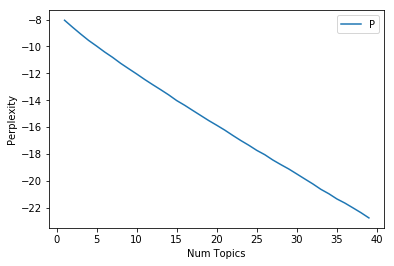

In [35]:
#If the perplexity score keeps decreasing, it may make better sense to pick the model 
#that gave the lowest perplexity before flattening out. This is exactly the case here.
x = range(1,40)
plt.plot(x, s)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity")
plt.legend(("Perplexity"), loc='best')
plt.show()
#Looks like 34 is optimal here? 

## LDA Mallet

In [17]:
mallet_path = '/Users/xinpengzheng/Downloads/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_tfidf, num_topics=20, id2word=dictionary_tr)

In [35]:
# Show Topics
print(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=doc_clean_test, dictionary=dictionary_te, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(2, [('catalytically', 1.0), ('bulky', 0.0), ('brightness', 0.0), ('pyridone', 0.0), ('functionalizations', 0.0), ('luminophores', 0.0), ('αβdehydrogenation', 0.0), ('βc–h', 0.0), ('alternating', 0.0), ('γδunsaturated', 0.0)]), (3, [('performance', 0.5), ('ticatalyzed', 0.5), ('pyridone', 0.0), ('cerium', 0.0), ('brightness', 0.0), ('understanding', 0.0), ('functionalizations', 0.0), ('bulky', 0.0), ('d2symmetrical', 0.0), ('γδunsaturated', 0.0)]), (13, [('luminophores', nan), ('alternating', nan), ('αβdehydrogenation', nan), ('βc–h', nan), ('γδunsaturated', nan), ('bulky', nan), ('functionalizations', nan), ('pyridone', nan), ('brightness', nan), ('cerium', nan)]), (1, [('node', 1.0), ('functionalizations', 0.0), ('cerium', 0.0), ('brightness', 0.0), ('pyridone', 0.0), ('bulky', 0.0), ('αβdehydrogenation', 0.0), ('βc–h', 0.0), ('understanding', 0.0), ('γδunsaturated', 0.0)]), (0, [('luminophores', nan), ('alternating', nan), ('αβdehydrogenation', nan), ('βc–h', nan), ('γδunsaturated'

/Users/xinpengzheng/anaconda3/lib/python3.6/site-packages/gensim/models/wrappers/ldamallet.py:442: RuntimeWarning: invalid value encountered in true_divide
  topic = topic / topic.sum()  # normalize to probability dist
/Users/xinpengzheng/anaconda3/lib/python3.6/site-packages/gensim/models/wrappers/ldamallet.py:373: RuntimeWarning: invalid value encountered in true_divide
  return topics / topics.sum(axis=1)[:, None]



Coherence Score:  0.6082382972756627


In [43]:
##Coherence of lda_tfidf model
coherence_model_ldatfidf = CoherenceModel(model=lda_model_tfidf, texts=doc_clean_test, dictionary=dictionary_te, coherence='c_v')
coherence_ldatfidf = coherence_model_ldatfidf.get_coherence()
print('\nCoherence Score: ', coherence_ldatfidf)


Coherence Score:  0.6426873833493799


In [29]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=num_topics, id2word=dictionary_tr, passes=2, workers=4)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [30]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary_te, corpus=corpus_tfidf_te, texts = doc_clean_test, start=2, limit=40, step=6)

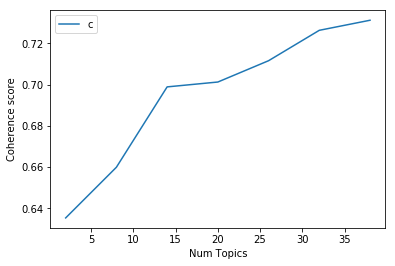

In [31]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [32]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6353
Num Topics = 8  has Coherence Value of 0.6599
Num Topics = 14  has Coherence Value of 0.6989
Num Topics = 20  has Coherence Value of 0.7012
Num Topics = 26  has Coherence Value of 0.7116
Num Topics = 32  has Coherence Value of 0.7263
Num Topics = 38  has Coherence Value of 0.7312


##### Pick the one after which the coherence starts to flatten out. In this case could be either 15 or 30. 